# <center> <img src="../../img/ITESOLogo.png" alt="ITESO" width="480" height="130"> </center>
# <center> **Departamento de Electrónica, Sistemas e Informática** </center>
---
## <center> Computer Systems Engineering  </center>
---
### <center> Big Data Processing </center>
---
#### <center> **Autumn 2025** </center>
---

**Final Project**: Batch Processing 

**Date**: October 27th 2025

**Student Name**: Luis Alberto González Escamilla

**Professor**: Pablo Camarillo Ramirez

# Introduction - Dyomorphos E-commerce Analytics Pipeline

## Dyomorphos E-commerce Analytics Pipeline

## Problem Statement

Dyomorphos is an independent clothing brand specializing in three core products: 
t-shirts, caps, and coats. As the brand grows its online presence, there is a critical 
need to understand customer behavior, track sales performance, and optimize inventory 
management.

## Business Objectives

This data pipeline addresses the following business needs:

1. **Sales Analytics**: Identify best-selling products, revenue trends, and seasonal patterns
2. **Customer Insights**: Understand customer purchasing behavior and identify loyal customers
3. **Inventory Management**: Track stock levels and predict reorder points
4. **Marketing Intelligence**: Identify which product categories and sizes drive the most revenue

## Expected Outcomes

By processing and analyzing Dyomorphos' sales data, the business can:
- Make data-driven decisions about inventory restocking
- Identify top customers for loyalty programs
- Optimize pricing strategies based on sales patterns
- Understand geographic distribution of customers for targeted marketing

## Technical Approach

This pipeline uses Apache Spark for distributed batch processing to:
- Ingest raw sales data from multiple CSV sources
- Clean and transform data to create analytical datasets
- Generate business metrics and KPIs
- Persist processed data in a database for reporting and visualization


# Dataset

### Data Model

This project uses a **Relational Data Model** stored in a denormalized CSV format. 
The relational model is ideal for this e-commerce use case because:

1. **Structured Transactions**: E-commerce data has clear relationships between entities 
   (customers, orders, products)
2. **ACID Properties**: Sales transactions require consistency and integrity
3. **Analytical Queries**: Relational models excel at aggregations, joins, and analytical 
   queries needed for business intelligence
4. **Normalization Flexibility**: While stored denormalized for efficiency, the data can 
   be normalized into separate tables (customers, products, orders, order_items) if needed

### Data Schema

The dataset contains a single denormalized table with the following schema:

**dyomorphos_sales**

| Column Name           | Data Type | Description                                    |
|-----------------------|-----------|------------------------------------------------|
| order_id              | Integer   | Unique identifier for each order               |
| order_date            | Date      | Date when the order was placed (YYYY-MM-DD)    |
| order_time            | Time      | Time when the order was placed (HH:MM:SS)      |
| customer_first_name   | String    | Customer's first name                          |
| customer_last_name    | String    | Customer's last name                           |
| customer_email        | String    | Customer's email address                       |
| customer_city         | String    | Customer's city                                |
| customer_state        | String    | Customer's state (2-letter abbreviation)       |
| customer_zip          | String    | Customer's ZIP code                            |
| product_id            | Integer   | Unique identifier for each product             |
| product_name          | String    | Name of the product                            |
| category              | String    | Product category (T-Shirt, Cap, Coat)          |
| size                  | String    | Product size (XS, S, M, L, XL, XXL, One Size)  |
| color                 | String    | Product color                                  |
| quantity              | Integer   | Quantity of items purchased                    |
| unit_price            | Float     | Price per unit (USD)                           |
| subtotal              | Float     | Subtotal before discounts (quantity × price)   |
| discount_amount       | Float     | Discount applied to the order (USD)            |
| shipping_cost         | Float     | Shipping cost (USD, 0 for free shipping)       |
| total_amount          | Float     | Final order total (USD)                        |
| payment_method        | String    | Payment method used                            |
| order_status          | String    | Order status (completed, pending, etc.)        |

### Dataset Generation

The dataset was generated using a custom Python script leveraging the Fake library 
to create realistic synthetic data. The generation process includes:

- **2,000 unique orders** spanning one year of sales history
- **14 distinct products** across three categories (T-Shirts, Caps, Coats)
- **Realistic business rules**: 
  - 65% completed orders, with remaining orders in various states
  - 10% of orders receive a discount
  - 30% of orders have free shipping
  - Multiple items per order with weighted distribution
  - Authentic customer information and geographic distribution

**Dataset Location**: `/home/linguini/O2025_ESI3914O/spark/data/ecommerce/dyomorphos_sales.csv`

**Generation Script**: `/home/linguini/O2025_ESI3914O/spark/lib/luis_gonzalez/generate_dyomorphos_data.py`

### Dataset Statistics

- **Total Records**: 3,008 sales transactions
- **Date Range**: October 2024 - October 2025
- **Total Revenue** (Completed Orders): $208,699.43
- **Average Order Value**: $159.77
- **Product Distribution**:
  - T-Shirts: 1,094 items sold
  - Coats: 1,126 items sold
  - Caps: 788 items sold

# Transformations and Actions

In [1]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Dyomorphos E-commerce Analytics Pipeline") \
    .master("spark://82b9407ec6fa:7077") \
    .config("spark.jars", "/opt/spark/work-dir/jars/postgresql-42.7.8.jar") \
    .config("spark.ui.port", "4040") \
    .getOrCreate()

sc = spark.sparkContext
sc.setLogLevel("ERROR")

25/10/28 04:25:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j2-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
from luis_gonzalez.spark_utils import SparkUtils

dyomorphos_schema_columns = [
    ("order_id", "int"),
    ("order_date", "string"),
    ("order_time", "string"),
    ("customer_first_name", "string"),
    ("customer_last_name", "string"),
    ("customer_email", "string"),
    ("customer_city", "string"),
    ("customer_state", "string"),
    ("customer_zip", "string"),
    ("product_id", "int"),
    ("product_name", "string"),
    ("category", "string"),
    ("size", "string"),
    ("color", "string"),
    ("quantity", "int"),
    ("unit_price", "float"),
    ("subtotal", "float"),
    ("discount_amount", "float"),
    ("shipping_cost", "float"),
    ("total_amount", "float"),
    ("payment_method", "string"),
    ("order_status", "string")
]

dyomorphos_schema = SparkUtils.generate_schema(dyomorphos_schema_columns)

In [3]:
df_sales = spark.read \
    .option("header", "true") \
    .schema(dyomorphos_schema) \
    .csv("/opt/spark/work-dir/data/ecommerce/dyomorphos_sales.csv")

In [4]:
from pyspark.sql.functions import trim, col, to_date, concat_ws, lower, when, lit

df_clean = df_sales \
    .dropDuplicates(["order_id", "product_id", "color", "size"]) \
    .withColumn("customer_first_name", trim("customer_first_name")) \
    .withColumn("customer_last_name", trim("customer_last_name")) \
    .withColumn("customer_email", lower(trim("customer_email"))) \
    .withColumn("customer_city", trim("customer_city")) \
    .withColumn("customer_state", trim("customer_state")) \
    .withColumn("product_name", trim("product_name")) \
    .withColumn("category", trim("category")) \
    .filter(col("order_status").isNotNull()) \
    .filter(col("total_amount") > 0)


In [5]:
from pyspark.sql.functions import year, month, dayofweek, hour, date_format

df_enriched = df_clean \
    .withColumn("order_datetime", to_date(col("order_date"), "yyyy-MM-dd")) \
    .withColumn("order_year", year(col("order_datetime"))) \
    .withColumn("order_month", month(col("order_datetime"))) \
    .withColumn("order_day_of_week", dayofweek(col("order_datetime"))) \
    .withColumn("month_name", date_format(col("order_datetime"), "MMMM")) \
    .withColumn("customer_full_name", concat_ws(" ", col("customer_first_name"), col("customer_last_name"))) \
    .withColumn("has_discount", when(col("discount_amount") > 0, lit(True)).otherwise(lit(False))) \
    .withColumn("free_shipping", when(col("shipping_cost") == 0, lit(True)).otherwise(lit(False))) \
    .withColumn("revenue", when(col("order_status") == "completed", col("total_amount")).otherwise(lit(0)))


In [6]:
# Transformation 1: Customer Summary Analytics
# Aggregate customer-level metrics
from pyspark.sql.functions import sum, avg, count, max, min

df_customer_summary = df_enriched \
    .groupBy("customer_email", "customer_full_name", "customer_city", "customer_state") \
    .agg(
        count("order_id").alias("total_orders"),
        sum("quantity").alias("total_items_purchased"),
        sum("revenue").alias("total_revenue"),
        avg("total_amount").alias("avg_order_value"),
        max("order_datetime").alias("last_order_date"),
        min("order_datetime").alias("first_order_date"),
        sum(when(col("has_discount"), 1).otherwise(0)).alias("orders_with_discount")
    )



In [7]:
# Transformation 2: Product Performance Analytics
# Analyze product sales performance by category, product, size, and color

df_product_performance = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("category", "product_id", "product_name", "size", "color") \
    .agg(
        sum("quantity").alias("units_sold"),
        sum("revenue").alias("total_revenue"),
        count("order_id").alias("number_of_orders"),
        avg("unit_price").alias("avg_unit_price")
    )


In [8]:
# Transformation 3: Time-based Sales Analytics
# Aggregate sales by time periods for trend analysis

df_monthly_sales = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("order_year", "order_month", "month_name", "category") \
    .agg(
        sum("revenue").alias("monthly_revenue"),
        sum("quantity").alias("monthly_units_sold"),
        count("order_id").alias("monthly_orders"),
        avg("total_amount").alias("avg_monthly_order_value")
    )


In [9]:
# Transformation 4: Geographic Sales Distribution
# Analyze sales by geographic location

df_geographic_sales = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("customer_state", "customer_city") \
    .agg(
        sum("revenue").alias("total_revenue"),
        count("order_id").alias("total_orders"),
        sum("quantity").alias("total_items"),
        avg("total_amount").alias("avg_order_value")
    )


In [10]:
# Transformation 5: Payment Method Analysis
# Analyze preferred payment methods and their revenue contribution

df_payment_analysis = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("payment_method") \
    .agg(
        count("order_id").alias("total_transactions"),
        sum("revenue").alias("total_revenue"),
        avg("total_amount").alias("avg_transaction_value")
    )


In [11]:
# Transformation 6: Order Status Distribution
# Analyze order fulfillment and status distribution

df_order_status = df_enriched \
    .groupBy("order_status") \
    .agg(
        count("order_id").alias("order_count"),
        sum("total_amount").alias("total_order_value"),
        avg("total_amount").alias("avg_order_value")
    )


In [12]:
# Transformation 7: Size and Color Preferences
# Identify popular sizes and colors by category

df_size_color_prefs = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("category", "size", "color") \
    .agg(
        sum("quantity").alias("units_sold"),
        sum("revenue").alias("revenue"),
        count("order_id").alias("order_count")
    )


In [13]:
# Transformation 8: Discount Impact Analysis
# Analyze the impact of discounts on sales

df_discount_impact = df_enriched \
    .filter(col("order_status") == "completed") \
    .groupBy("has_discount", "category") \
    .agg(
        count("order_id").alias("order_count"),
        sum("revenue").alias("total_revenue"),
        avg("total_amount").alias("avg_order_value"),
        sum("discount_amount").alias("total_discount_given")
    )


# Persistence Data

### Database Selection and Justification

For the Dyomorphos e-commerce analytics pipeline, PostgreSQL has been selected as the persistence layer. This choice is justified by the following factors:

#### Why PostgreSQL (Relational SQL Database)?

1. **Structured Relational Data**: The Dyomorphos dataset is inherently relational with clear relationships between customers, orders, products, and transactions. PostgreSQL excels at maintaining referential integrity and supporting complex joins.

2. **ACID Compliance**: E-commerce transactions require strong consistency guarantees. PostgreSQL provides full ACID (Atomicity, Consistency, Isolation, Durability) compliance, ensuring data integrity for financial transactions.

3. **Complex Analytical Queries**: The transformed datasets include aggregations, time-series analysis, and multi-dimensional analytics. PostgreSQL's advanced query optimizer and indexing capabilities make it ideal for business intelligence workloads.

4. **Mature Ecosystem**: PostgreSQL offers robust integration with BI tools (Power BI, Tableau), excellent Spark JDBC connector support, and widespread enterprise adoption.

5. **Scalability**: While NoSQL databases offer horizontal scalability, PostgreSQL provides sufficient vertical scalability for Dyomorphos' current data volume (~3,000 records) with room to grow to millions of transactions.

#### Why Not NoSQL?

- **MongoDB**: Would be suitable if data schema was highly variable or nested, but Dyomorphos data is well-structured and tabular.
- **Cassandra**: Optimized for write-heavy workloads with simple queries; our use case is read-heavy analytics.
- **Neo4j**: Better for relationship-heavy queries (social networks, recommendations); not necessary for straightforward e-commerce analytics.

### Database Schema Design

The following tables will be created in PostgreSQL:

1. **customer_summary**: Customer-level aggregated metrics
2. **product_performance**: Product sales performance by variant
3. **monthly_sales**: Time-series sales data by month and category
4. **geographic_sales**: Sales distribution by location
5. **payment_analysis**: Payment method performance metrics
6. **order_status_summary**: Order fulfillment statistics
7. **size_color_preferences**: Product attribute preferences
8. **discount_impact**: Discount effectiveness analysis

In [14]:
jdbc_url = "jdbc:postgresql://postgres-iteso:5432/postgres"
db_properties = {
    "user": "postgres",
    "password": "Admin@1234",
    "driver": "org.postgresql.Driver"
}

In [15]:
# Persist Table 1: Customer Summary
print("Writing customer_summary table to PostgreSQL...")
df_customer_summary.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_customer_summary") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Customer summary success")

Writing customer_summary table to PostgreSQL...


[Stage 5:>                                                          (0 + 1) / 1]

Customer summary success


In [16]:
# Persist Table 2: Product Performance
print("Writing product_performance table to PostgreSQL...")
df_product_performance.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_product_performance") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Product performance success")

Writing product_performance table to PostgreSQL...
Product performance success


In [17]:
# Persist Table 3: Monthly Sales
print("Writing monthly_sales table to PostgreSQL...")
df_monthly_sales.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_monthly_sales") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Monthly sales success")

Writing monthly_sales table to PostgreSQL...
Monthly sales success


In [18]:
# Persist Table 4: Geographic Sales Distribution
print("Writing geographic_sales table to PostgreSQL...")
df_geographic_sales.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_geographic_sales") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Geographic sales")

Writing geographic_sales table to PostgreSQL...


[Stage 20:>                                                         (0 + 1) / 1]

Geographic sales


In [19]:
# Persist Table 5: Payment Method Analysis
print("Writing payment_analysis table to PostgreSQL...")
df_payment_analysis.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_payment_analysis") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Payment analysis success")

Writing payment_analysis table to PostgreSQL...
Payment analysis success


In [20]:
# Persist Table 6: Order Status Summary
print("Writing order_status table to PostgreSQL...")
df_order_status.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_order_status") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Order status success")

Writing order_status table to PostgreSQL...
Order status success


In [21]:
# Persist Table 7: Size and Color Preferences
print("Writing size_color_preferences table to PostgreSQL...")
df_size_color_prefs.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_size_color_prefs") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Size and color preferences success")

Writing size_color_preferences table to PostgreSQL...
Size and color preferences success


In [22]:
# Persist Table 8: Discount Impact Analysis
print("Writing discount_impact table to PostgreSQL...")
df_discount_impact.write \
    .format("jdbc") \
    .option("url", jdbc_url) \
    .option("dbtable", "dyomorphos_discount_impact") \
    .option("user", db_properties["user"]) \
    .option("password", db_properties["password"]) \
    .option("driver", db_properties["driver"]) \
    .mode("overwrite") \
    .save()

print("Discount impact success")

Writing discount_impact table to PostgreSQL...
Discount impact success


# Data Verification

In [25]:
# Verify Table 1: Customer Summary
print("TABLE 1: DYOMORPHOS_CUSTOMER_SUMMARY")

df_customer_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_customer_summary", properties=db_properties)

df_customer_verify.show(3)
print(f"Total records: {df_customer_verify.count()}")

TABLE 1: DYOMORPHOS_CUSTOMER_SUMMARY
+--------------------+------------------+-------------+--------------+------------+---------------------+-----------------+-----------------+---------------+----------------+--------------------+
|      customer_email|customer_full_name|customer_city|customer_state|total_orders|total_items_purchased|    total_revenue|  avg_order_value|last_order_date|first_order_date|orders_with_discount|
+--------------------+------------------+-------------+--------------+------------+---------------------+-----------------+-----------------+---------------+----------------+--------------------+
|william.martinez@...|  William Martinez|    Port Troy|            MN|           1|                    2|59.97999954223633|59.97999954223633|     2025-01-09|      2025-01-09|                   0|
|susan.meyer@gmail...|       Susan Meyer|  Danielsfurt|            CO|           1|                    2|267.9700012207031|267.9700012207031|     2025-08-10|      2025-08-10|     

In [27]:
# Verify Table 2: Product Performance
print("TABLE 2: DYOMORPHOS_PRODUCT_PERFORMANCE")

df_product_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_product_performance", properties=db_properties)

df_product_verify.orderBy("total_revenue", ascending=False).show(3)
print(f"Total records: {df_product_verify.count()}")

TABLE 2: DYOMORPHOS_PRODUCT_PERFORMANCE
+--------+----------+------------------+----+-----+----------+------------------+----------------+------------------+
|category|product_id|      product_name|size|color|units_sold|     total_revenue|number_of_orders|    avg_unit_price|
+--------+----------+------------------+----+-----+----------+------------------+----------------+------------------+
|    Coat|        10|Winter Puffer Coat|  XL|White|        13| 2525.800003051758|               9|189.99000549316406|
|    Coat|        10|Winter Puffer Coat|   L| Navy|        12|2335.8099975585938|               8|189.99000549316406|
|    Coat|        10|Winter Puffer Coat|   M|Olive|        12|2289.8200073242188|               8|189.99000549316406|
+--------+----------+------------------+----+-----+----------+------------------+----------------+------------------+
only showing top 3 rows
Total records: 398


In [28]:
# Verify Table 3: Monthly Sales
print("TABLE 3: DYOMORPHOS_MONTHLY_SALES")

df_monthly_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_monthly_sales", properties=db_properties)

df_monthly_verify.orderBy("order_year", "order_month").show(3)
print(f"Total records: {df_monthly_verify.count()}")

TABLE 3: DYOMORPHOS_MONTHLY_SALES
+----------+-----------+----------+--------+------------------+------------------+--------------+-----------------------+
|order_year|order_month|month_name|category|   monthly_revenue|monthly_units_sold|monthly_orders|avg_monthly_order_value|
+----------+-----------+----------+--------+------------------+------------------+--------------+-----------------------+
|      2024|         10|   October| T-Shirt| 600.2900104522705|                15|            10|      60.02900104522705|
|      2024|         10|   October|     Cap|302.85000228881836|                10|             6|      50.47500038146973|
|      2024|         10|   October|    Coat|1782.8000106811523|                13|             9|      198.0888900756836|
+----------+-----------+----------+--------+------------------+------------------+--------------+-----------------------+
only showing top 3 rows
Total records: 39


In [29]:
# Verify Table 4: Geographic Sales
print("TABLE 4: DYOMORPHOS_GEOGRAPHIC_SALES")

df_geographic_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_geographic_sales", properties=db_properties)

df_geographic_verify.orderBy("total_revenue", ascending=False).show(3)
print(f"Total records: {df_geographic_verify.count()}")

TABLE 4: DYOMORPHOS_GEOGRAPHIC_SALES
+--------------+-------------+-----------------+------------+-----------+-----------------+
|customer_state|customer_city|    total_revenue|total_orders|total_items|  avg_order_value|
+--------------+-------------+-----------------+------------+-----------+-----------------+
|            LA|    Gomezport|387.9700012207031|           1|          2|387.9700012207031|
|            LA|    Smithbury|387.9700012207031|           1|          2|387.9700012207031|
|            WY|South Micheal|387.9700012207031|           1|          2|387.9700012207031|
+--------------+-------------+-----------------+------------+-----------+-----------------+
only showing top 3 rows
Total records: 1968


In [30]:
# Verify Table 5: Payment Analysis
print("TABLE 5: DYOMORPHOS_PAYMENT_ANALYSIS")

df_payment_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_payment_analysis", properties=db_properties)

df_payment_verify.show(3)
print(f"Total records: {df_payment_verify.count()}")

TABLE 5: DYOMORPHOS_PAYMENT_ANALYSIS
+--------------+------------------+------------------+---------------------+
|payment_method|total_transactions|     total_revenue|avg_transaction_value|
+--------------+------------------+------------------+---------------------+
|        paypal|               492|52366.940284729004|   106.43687049741668|
|     apple_pay|               538|  56576.5703868866|   105.16091149978921|
|   credit_card|               482| 49670.20037269592|   103.05020824210773|
+--------------+------------------+------------------+---------------------+
only showing top 3 rows
Total records: 4


In [31]:
# Verify Table 6: Order Status Summary
print("TABLE 6: DYOMORPHOS_ORDER_STATUS")

df_status_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_order_status", properties=db_properties)

df_status_verify.show(3)
print(f"Total records: {df_status_verify.count()}")

TABLE 6: DYOMORPHOS_ORDER_STATUS
+------------+-----------+------------------+------------------+
|order_status|order_count| total_order_value|   avg_order_value|
+------------+-----------+------------------+------------------+
|   completed|       1970|  208699.431432724|105.93879768158578|
|     shipped|        450|48081.910345077515|106.84868965572781|
|   cancelled|        209|21971.910165786743|105.12875677409924|
+------------+-----------+------------------+------------------+
only showing top 3 rows
Total records: 5


In [32]:
# Verify Table 7: Size and Color Preferences
print("TABLE 7: DYOMORPHOS_SIZE_COLOR_PREFS")

df_prefs_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_size_color_prefs", properties=db_properties)

df_prefs_verify.orderBy("units_sold", ascending=False).show(3)
print(f"Total records: {df_prefs_verify.count()}")

TABLE 7: DYOMORPHOS_SIZE_COLOR_PREFS
+--------+--------+--------+----------+------------------+-----------+
|category|    size|   color|units_sold|           revenue|order_count|
+--------+--------+--------+----------+------------------+-----------+
|     Cap|One Size|Charcoal|       132|3844.8100051879883|         83|
|     Cap|One Size|Burgundy|       124|3631.8100261688232|         78|
|     Cap|One Size|    Navy|       119| 3420.630002975464|         78|
+--------+--------+--------+----------+------------------+-----------+
only showing top 3 rows
Total records: 84


In [33]:
# Verify Table 8: Discount Impact
print("TABLE 8: DYOMORPHOS_DISCOUNT_IMPACT")

df_discount_verify = spark.read \
    .jdbc(url=jdbc_url, table="dyomorphos_discount_impact", properties=db_properties)

df_discount_verify.show(3)
print(f"Total records: {df_discount_verify.count()}")

TABLE 8: DYOMORPHOS_DISCOUNT_IMPACT
+------------+--------+-----------+------------------+-----------------+--------------------+
|has_discount|category|order_count|     total_revenue|  avg_order_value|total_discount_given|
+------------+--------+-----------+------------------+-----------------+--------------------+
|       false| T-Shirt|        675| 43051.13059425354|63.77945273222747|                 0.0|
|        true| T-Shirt|         65| 3339.810031890869|51.38169279832106|   333.9000024795532|
|        true|     Cap|         53|2151.2099933624268|40.58886779929107|  203.59999990463257|
+------------+--------+-----------+------------------+-----------------+--------------------+
only showing top 3 rows
Total records: 6


# DAG

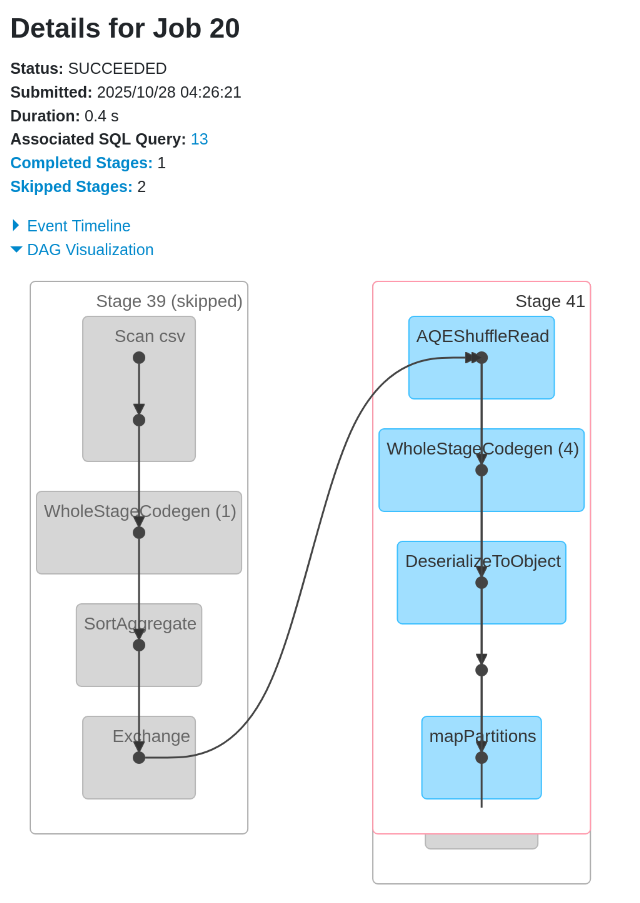

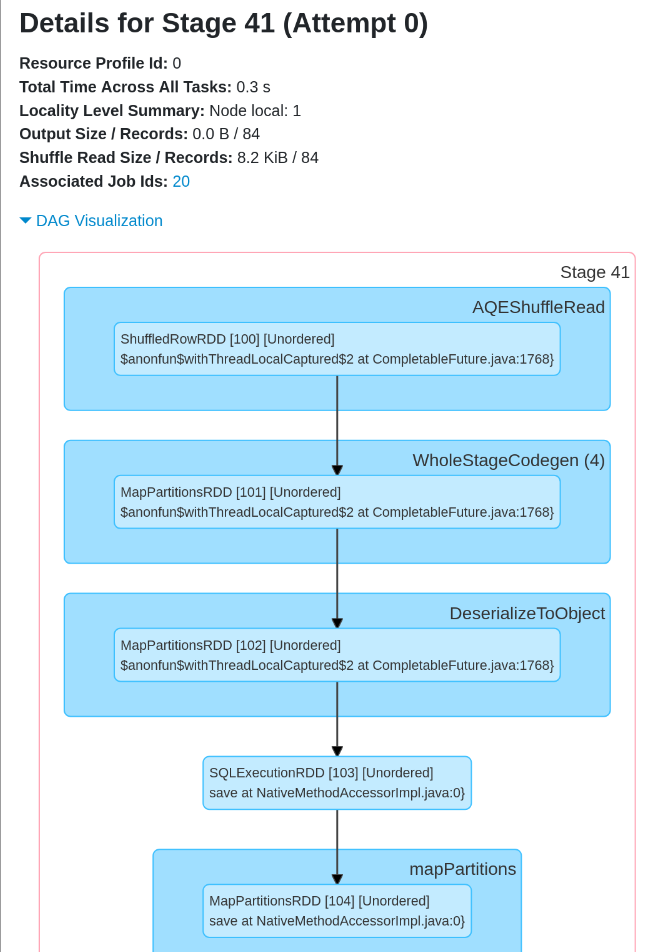